## U-net model

This notebook contains the code for initializing and training the model

In [5]:
def restart_kernel(restart=False):
    import IPython
    app = IPython.Application.instance()
    if restart:
        app.kernel.do_shutdown(True)

restart_kernel(False)

import os
os.environ["THEANO_FLAGS"] = "device=cpu,lib.cnmem=0"

In [6]:
import numpy as np
import keras
from keras.models import Model
from keras.layers import Input, Concatenate, Activation, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, ZeroPadding2D, Cropping2D, BatchNormalization, Dropout
from keras.optimizers import Adadelta, Adam
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils.io_utils import HDF5Matrix
from keras.preprocessing.image import ImageDataGenerator

#import skimage.exposure
#import cv2
import h5py

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from pushbullet import Pushbullet

import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
import time
import multiprocessing

In [7]:
# Define the push function that can be called later
def push(title='Done!',text=''):
    Pushbullet('o.YFPNNPfGRekivaCGHa4qMSgjZt8zJ6FL').devices[0].push_note(title,text)
def push_url(title='Link',url=''):
    Pushbullet('o.YFPNNPfGRekivaCGHa4qMSgjZt8zJ6FL').devices[0].push_link(title,url)    

In [8]:
# Increment the counter
def counter():
    run = np.load('./data/misc/run_counter.npy')
    run += 1
    np.save('./data/misc/run_counter.npy',run)
    return run
run = counter()

# Set the counter to a specific value
def set_counter(run):
    run = run
    np.save('./data/misc/run_counter.npy',run)
    return run
# Uncomment the next line to manually set the counter if something goes wrong
#run = set_counter(15)
print('This is run # %i' %run)

This is run # 20


In [13]:
# Get stream IDs
stream_tokens = tls.get_credentials_file()['stream_ids']

stream_id1 = dict(token=stream_tokens[-1], maxpoints=600)
stream_id2 = dict(token=stream_tokens[-2], maxpoints=600)
stream_id3 = dict(token=stream_tokens[-3], maxpoints=600)
stream_id4 = dict(token=stream_tokens[-4], maxpoints=600)        

# Define traces
loss = go.Scatter(x=[], y=[], name='Loss', stream=stream_id1, mode='lines+markers',yaxis='y', line=dict(shape='spline',smoothing=1))
jaccard = go.Scatter(x=[], y=[], name='Jaccard', stream=stream_id2, mode='lines+markers',yaxis='y2', line=dict(shape='spline',smoothing=1))
val_loss = go.Scatter(x=[], y=[], name='Val Loss', stream=stream_id3, mode='lines+markers',yaxis='y', line=dict(shape='spline',smoothing=1))
val_jaccard = go.Scatter(x=[], y=[], name='Val Jaccard', stream=stream_id4, mode='lines+markers',yaxis='y2', line=dict(shape='spline',smoothing=1))

# Define data and layout
data = [loss, jaccard, val_loss, val_jaccard]
layout = go.Layout(title='Loss/Jaccard for run {}'.format(run),
                   yaxis=dict(title='Loss',type='log',autorange=True),
                   yaxis2=dict(title='Jaccard index',overlaying='y',side='right',range=[0,1]))

# Generate plot
plotly_fig = go.Figure(data=data, layout=layout)

# Define streams
loss_stream = py.Stream(stream_id=stream_tokens[-1])
jaccard_stream = py.Stream(stream_id=stream_tokens[-2])
val_loss_stream = py.Stream(stream_id=stream_tokens[-3])
val_jaccard_stream = py.Stream(stream_id=stream_tokens[-4])
    
# Define class for streamer callback
class streamer(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        
        # Initialize plot, get url, save url to npy file and push url to pixel
        url = py.plot(plotly_fig, filename='deep_microscopy_run_{}'.format(run));
        np.save('./data/logs/nuclei_plotly_url_run_{}'.format(run),url)
        push_url('Plotly link for run {}'.format(run),str(url+'.embed'))
        
        # Open streams
        loss_stream.open()
        jaccard_stream.open()
        val_loss_stream.open()
        val_jaccard_stream.open()
        
        # Initialize logs
        self.i = 1
        self.x = []
        self.losses = []
        self.val_losses = []
        self.jaccards = []
        self.val_jaccards = []
        self.logs = []
        
        # Keep the connection alive
        training = True
        def heartbeater():
            while training:
                loss_stream.heartbeat()
                jaccard_stream.heartbeat()
                val_loss_stream.heartbeat()
                val_jaccard_stream.heartbeat()
                time.sleep(5)
                
        t = multiprocessing.Process(target=heartbeater)
        t.start()       
        
    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i) # potentially switch to self.epoch?
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.jaccards.append(logs.get('jaccard'))
        self.val_jaccards.append(logs.get('val_jaccard'))
        self.i += 1
        
        loss_stream.write(dict(x=self.x, y=self.losses))
        jaccard_stream.write(dict(x=self.x, y=self.jaccards))
        val_loss_stream.write(dict(x=self.x, y=self.val_losses))
        val_jaccard_stream.write(dict(x=self.x, y=self.val_jaccards))
        
    def on_train_end(self,logs={}):
        # Kill the heartbeater
        training = False
        
        # Close the streams
        loss_stream.close()
        jaccard_stream.close()
        val_loss_stream.close()
        val_jaccard_stream.close()
        
streamer = streamer()

In [10]:
# Outline arguments
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     fill_mode='reflect',
                     horizontal_flip=True,
                     vertical_flip=True,
                     data_format='channels_last')

# Initialize generators
img_datagen = ImageDataGenerator(**data_gen_args)
#msk_datagen = ImageDataGenerator(**data_gen_args)

# Make data sources
filename = 'mosaic_1'
with h5py.File('./data/training-data/{}.hdf5'.format(filename),'r+') as f:
    x = f['x'][:,:,:,2:3]
    y = f['y_nuclei'][...]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25, random_state=42)
#del x,y

# Fit the generators
seed=1
img_datagen.fit(x_train,augment=True,seed=seed)
#msk_datagen.fit(y_train,augment=True,seed=seed)

batch_size = 5

img_train_generator = img_datagen.flow(x=x_train,batch_size=batch_size,shuffle=False,seed=seed)
msk_train_generator = img_datagen.flow(x=y_train,batch_size=batch_size,shuffle=False,seed=seed)

img_val_generator = img_datagen.flow(x=x_val,batch_size=batch_size,shuffle=False,seed=seed)
msk_val_generator = img_datagen.flow(x=y_val,batch_size=batch_size,shuffle=False,seed=seed)

train_generator = zip(img_train_generator, msk_train_generator)
val_generator = zip(img_val_generator, msk_val_generator)

# Call the flow() method
#model.fit_generator(train_generator,
#                    steps_per_epoch=196, epochs=100,validation_data='XXX', callbacks)

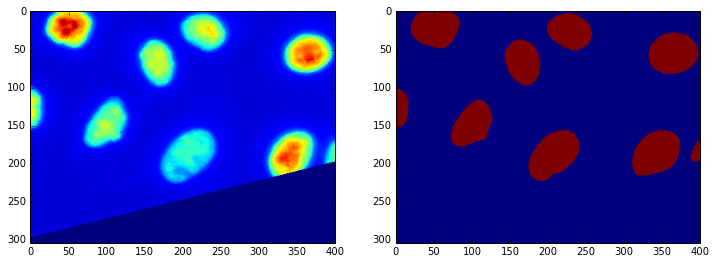

In [49]:
fig = plt.figure(figsize=(12,12))
    
ax = fig.add_subplot(121)
ax.imshow(img_train_generator.next()[0,:,:,0])
ax = fig.add_subplot(122)
ax.imshow(msk_train_generator.next()[0,:,:,0])
plt.show()


In [11]:
%%time
def compiler(img_rows = x_train.shape[1],img_cols = x_train.shape[2],
            nfilters = 64, act = 'relu',init = 'he_normal',
            lr=0.001,decay=0.0,rate=[0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2],transpose=False):
    
    def jaccard(y_true, y_pred,smooth=1.):
        intersection = K.sum(y_true * y_pred)
        return (intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) - intersection + smooth)
    
    def Conv2DReluBatchNorm(n_filter, filter_size, layer_in, activation, kernel_initializer='he_uniform'):
        return BatchNormalization(axis=-1)(Activation(activation=act)((Conv2D(n_filter, filter_size, padding='same',kernel_initializer=init)(layer_in))))
        
    def up_conv(nfilters,filter_factor,layer_in,kernel_initializer=init,activation=act):
        if transpose: # This will perform transposed convolution
            return BatchNormalization(axis=-1)(Activation(activation=act)(Conv2D(nfilters*filter_factor, (2, 2), padding='same',kernel_initializer=init)(Conv2DTranspose(nfilters*filter_factor,(2,2),strides=2,padding='valid',kernel_initializer=init,activation='relu',data_format='channels_last')(layer_in))))
        else: # This is the original upsampling operation
            return BatchNormalization(axis=-1)(Activation(activation=act)(Conv2D(nfilters*filter_factor, (2, 2), padding='same',kernel_initializer=init)(UpSampling2D(size=(2, 2))(layer_in))))
        
    inputs = Input((img_rows, img_cols,1))
    
    conv1 = Conv2DReluBatchNorm(nfilters, (3, 3), inputs, activation=act,kernel_initializer=init)
    conv1 = Conv2DReluBatchNorm(nfilters, (3, 3), conv1, activation=act,kernel_initializer=init)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(rate=rate[0])(pool1)

    conv2 = Conv2DReluBatchNorm(nfilters*2, (3, 3), pool1, activation=act,kernel_initializer=init)
    conv2 = Conv2DReluBatchNorm(nfilters*2, (3, 3), conv2, activation=act,kernel_initializer=init)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(rate=rate[1])(pool2)

    conv3 = Conv2DReluBatchNorm(nfilters*4, (3, 3), pool2, activation=act,kernel_initializer=init)
    conv3 = Conv2DReluBatchNorm(nfilters*4, (3, 3), conv3, activation=act,kernel_initializer=init)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(rate=rate[2])(pool3)

    conv4 = Conv2DReluBatchNorm(nfilters*8, (3, 3), pool3, activation=act,kernel_initializer=init)
    conv4 = Conv2DReluBatchNorm(nfilters*8, (3, 3), conv4, activation=act,kernel_initializer=init)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(rate=rate[3])(pool4)

    conv5 = Conv2DReluBatchNorm(nfilters*16, (3, 3), pool4, activation=act,kernel_initializer=init)
    conv5 = Conv2DReluBatchNorm(nfilters*16, (3, 3), conv5, activation=act,kernel_initializer=init)
    conv5 = Dropout(rate=rate[4])(conv5)
        
    up6 = Concatenate(axis=3)([up_conv(nfilters,8,conv5), conv4])
    #up6 = merge([up_conv(nfilters,8,conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Conv2DReluBatchNorm(nfilters*8, (3, 3), up6, activation=act,kernel_initializer=init)
    conv6 = Conv2DReluBatchNorm(nfilters*8, (3, 3), conv6, activation=act,kernel_initializer=init)
    conv6 = Dropout(rate=rate[5])(conv6)
    
    up7 = Concatenate(axis=3)([up_conv(nfilters,4,conv6), conv3])
    #up7 = merge([up_conv(nfilters,4,conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Conv2DReluBatchNorm(nfilters*4, (3, 3), up7, activation=act,kernel_initializer=init)
    conv7 = Conv2DReluBatchNorm(nfilters*4, (3, 3), conv7, activation=act,kernel_initializer=init)
    conv7 = Dropout(rate=rate[6])(conv7)
    
    up8 = Concatenate(axis=3)([up_conv(nfilters,2,conv7), conv2])
    #up8 = merge([up_conv(nfilters,2,conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Conv2DReluBatchNorm(nfilters*2, (3, 3), up8, activation=act,kernel_initializer=init)
    conv8 = Conv2DReluBatchNorm(nfilters*2, (3, 3), conv8, activation=act,kernel_initializer=init)
    conv8 = Dropout(rate=rate[7])(conv8)

    up9 = Concatenate(axis=3)([up_conv(nfilters,1,conv8), conv1])
    #up9 = merge([up_conv(nfilters,1,conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Conv2DReluBatchNorm(nfilters, (3, 3), up9, activation=act,kernel_initializer=init)
    conv9 = Conv2DReluBatchNorm(nfilters, (3, 3), conv9, activation=act,kernel_initializer=init)
    conv9 = Dropout(rate=rate[8])(conv9)
    
    conv10 = Conv2DReluBatchNorm(1, (1, 1), conv9, activation=act,kernel_initializer=init)
    output = Activation(activation='sigmoid')(conv10)
    
    model = Model(inputs=inputs, outputs=output)
    
    model.compile(optimizer=Adam(lr=lr,decay=decay), loss='binary_crossentropy',metrics=[jaccard])

    return model

rate=[0]*9
#rate=[0.1,0.2,0.3,0.4,0.5,0.4,0.3,0.2,0.1] # current version
#rate=[0.2,0.3,0.4,0.5,0.5,0.5,0.4,0.3,0.2] # symmetric but more dropout
#rate=[0.2,0.2,0.3,0.3,0.4,0.4,0.5,0.5,0.6] # increasing

model = compiler(img_rows=x_train.shape[1],img_cols=x_train.shape[2],
            nfilters=4,act='relu',init='he_normal',
            lr=0.001,rate=rate,transpose=False)
model.save_weights('./data/misc/initial_weights.hdf5')
#model.summary()

CPU times: user 3.58 s, sys: 53 ms, total: 3.63 s
Wall time: 3.73 s


In [ ]:
def trainer(model,epochs=1000,fit=True,use_existing=False):
    print('This is run # {}'.format(run))
    
    if use_existing:
        model.load_weights('./data/weights/model_weights_nuclei_run_{}.hdf5'.format(run))
        
    if fit:
        quitter = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=50, verbose=1, mode='auto')
        lrreducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1, mode='auto', epsilon=0.001, cooldown=2, min_lr=0)
        model_checkpoint = ModelCheckpoint('./data/weights/model_weights_run_{}_nuclei.hdf5'.format(run), monitor='val_loss', save_best_only=True)
        csvlogger = CSVLogger('./data/logs/training_log_run_{}_nuclei.csv'.format(run), separator=',', append=True)
        # tensorboard = TensorBoard(log_dir='./data/logs/'+'tensorboard_all-classes-run_{:04d}'.format(run), histogram_freq=0, write_graph=True, write_images=False)
        # tensorboard --logdir=data/logs

        model.fit_generator(train_generator,
                            steps_per_epoch=15, epochs=50,validation_data=val_generator,
                            validation_steps=5,callbacks=[model_checkpoint,csvlogger,streamer],
                           verbose=1)
            
    preds = model.predict(x, verbose=1)
    np.save('./data/predictions/predictions_run_{}_nuclei.npy'.format(run), preds)
    
    return model

model = trainer(model,fit=True,use_existing=False)
model.save('./data/models/u-net-complete-model-run_{}_nuclei.hdf5'.format(run))
push('Training  is done',
 'Train loss: %f, train jaccard: %f' %(model.history.history['loss'][-1],model.history.history['jaccard'][-1]))

This is run # 20
Epoch 1/50
15/15 [==============================] - 44s - loss: 0.4940 - jaccard: 0.3060 - val_loss: 0.6324 - val_jaccard: 0.1789